In [10]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve, brentq
from scipy.constants import N_A
import matplotlib.pyplot as plt
import seaborn as sns
import math
from numba import njit
import nbkode

In [11]:
#Constants

Target_cell_number = 1e4
E_T_ratio = 1
well_size = 150e-6
sigma = well_size*N_A/Target_cell_number
synapse_gap = 25e-9
synapse_width = 10e-6
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 3.25e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
assay_to_synapse_conversion = (synapse_width**2*synapse_gap)/well_size
sigma_synapse = sigma*assay_to_synapse_conversion
synapse_area = synapse_width**2

In [12]:
def lig_comp(t, z, ftot, x1tot, x2tot, k1, k2, koff):

    dx1 = k1*(ftot-z[0]-z[1])*(x1tot-z[0]) - koff*z[0]
    dx2 = k2*(ftot-z[0]-z[1])*(x2tot-z[1]) - koff*z[1]

    dz = [dx1, dx2]

    return dz

In [13]:
CD4_variants = ['Ibalizumab', 'VKY91A', 'VKR95A', 'VHY99A']
CD4_on_rates = [2.1e5, 1.7e5, 3e5, 2.8e5]
CD4_off_rates = [1.8e-4, 4.2e-3, 1.6e-2, 2.e-2]
#CD4_on_rates = [1e5, 1e5, 1e5, 1e5]
#CD4_off_rates = [1e-4, 1e-3, 1e-2, 5e-2]


A0s = np.geomspace(1e-12, 1e-4, 75)

t_end = 60*60*10000
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]

In [14]:
def A1_steady_state(x, Atot, k1, koff, k2, rtot):
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

#Effector cell opsonization

def effector_A1(ftot, Atot, Q_D):

    a = 1
    b = -(ftot + Atot + Q_D)
    c = ftot*Atot

    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

@njit
def S_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot_synapse, rtot_fc_synapse, Atot):


    A0 = Atot - (z[0] + z[1] + z[3] + z[4] + z[2])
    rt = rtot_synapse- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc_synapse - z[2] - (z[3] + z[4])
    
    dA10 =  2*k1*(A0)*(rt) - k1off*z[0] - k2*z[0]*(rt) + 2*1*k1off*z[1] - k4*z[0]*(rf) + 1*k2off*z[3]
    dA20 = k2*z[0]*(rt) - 2*1*k1off*z[1] - k5*z[1]*(rf) + 1*k2off*z[4]
    dA01 =  k3*(A0)*(rf) - 2*k2off*z[2] - 2*k6*1*z[2]*(rt) + k1off*1*z[3]
    dA11 = k4*z[0]*(rf) - 1*k2off*z[3] + 2*k6*1*z[2]*(rt) -k1off*1*z[3] - k7*z[3]*(rt) + 2*1*k1off*z[4]
    dA21 = k5*z[1]*(rf) - 1*k2off*z[4] + k7*z[3]*(rt) - 2*1*k1off*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz
  

def R_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot, rtot_fc, Atot):


    A0 = (Atot - (z[0] + z[1] + z[3] + z[4] + z[2]))
    rt = rtot- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc - z[2] - (z[3] + z[4])
    
    dA10 = 2*k1*(A0)*(rt) - k1off*z[0] - k2*z[0]*(rt/rtot) + 2*k1off*z[1] - k4*z[0]*(rf/rtot_fc) + k2off*z[3]
    dA20 = k2*z[0]*(rt/rtot) - 2*k1off*z[1] - k5*z[1]*(rf/rtot_fc) + k2off*z[4]
    dA01 = k3*(A0)*(rf) - k2off*z[2] - 2*k6*z[2]*(rt/rtot) + k1off*z[3]
    dA11 = k4*z[0]*(rf/rtot_fc) - k2off*z[3] + 2*k6*z[2]*(rt/rtot) -k1off*z[3] - k7*z[3]*(rt/rtot) + 2*k1off*z[4]
    dA21 = k5*z[1]*(rf/rtot_fc) - k2off*z[4] + k7*z[3]*(rt/rtot) - 2*k2off*z[4]

    dz = [dA10, dA20, dA01, dA11, dA21]
    return np.asarray(dz, dtype="object")

In [15]:
def two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot, rtot_fc, Atot):

    k2off = 2*k1off
    k3off = k2off
    k4off = k2off
    k5off = k2off
    k6off = k1off
    k7off = 2*k1off
    gamma2 = k2off/k1off
    gamma3 = k3off/k1off
    gamma4 = k4off/k1off
    gamma5 = k5off/k1off
    gamma6 = k6off/k1off
    gamma7 = k7off/k1off


    alpha1 = k1/k1off
    alpha2 = k2/k1off
    alpha3 = k3/k1off
    alpha4 = k4/k1off
    alpha5 = k5/k1off
    alpha6 = k6/k1off
    alpha7 = k7/k1off

    phi = rtot/rtot_fc
    #beta_synapse = 1e1*Atot/sigma
    #beta_t = beta_synapse + A10_0 + A20_0 + (A01_0/phi)
    #beta_f = phi*beta_t
    
    #A00 = (1 - (1/beta_t)*(z[0] + z[1] + z[3] + z[4] + (1/phi)*z[2]))
    rt = 1- z[0] - z[3] - 2*(z[1] + z[4])
    rf = 1 - z[2] - phi*(z[3] + z[4])

    dA10 =  - alpha2*z[0]*(rt) + gamma2*z[1] - alpha4*z[0]*(rf) + gamma4*z[3]
    dA20 = alpha2*z[0]*(rt) - gamma2*z[1] - alpha5*z[1]*(rf) + gamma5*z[4]
    dA01 = - gamma3*z[2] - alpha6*z[2]*(rt) + gamma6*phi*z[3]
    dA11 = alpha4*z[0]*(rf) - gamma4*z[3] + (alpha6/phi)*z[2]*(rt) - gamma6*z[3] - alpha7*z[3]*(rt) + gamma7*z[4]
    dA21 = alpha5*z[1]*(rf) - gamma5*z[4] + alpha7*z[3]*(rt) - gamma7*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

def nondim_synapse(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot, rtot_fc, Atot):

    phi = np.log10(rtot_fc/rtot)
    beta_synapse = np.log10(Atot/rtot)
    alpha_1 = k1*rtot/k1off
    alpha_2 = k2*rtot/k1off
    alpha_3 = k3*rtot_fc/k1off
    alpha_4 = k4*rtot_fc/k1off
    alpha_5 = k5*rtot_fc/k1off
    alpha_6 = k6*rtot/k1off
    alpha_7 = k7*rtot/k1off
    gamma = np.log10(k2off/k1off)

    rt = np.log10(1) - (z[0] + 2*z[1]) - phi*(z[3] + 2*z[4])
    rf = np.log10(1) - (z[2] + z[3] + z[4])
    A0 = beta_synapse - (z[0] + z[1] + phi*(z[2] + z[3] + z[4]))

    dA10 = 2*alpha_1*A0*rt - z[0] - alpha_2*z[0]*rt + 2*z[1] - alpha_4*z[0]*rf + gamma*phi*z[3]
    dA20 = alpha_2*z[0]*rt -2*z[1] - alpha_5*z[1]*rf + gamma*phi*z[4]
    dA01 = alpha_3*phi*A0*rf - gamma*z[2] - 2*alpha_6*z[2]*rt + z[3]
    dA11 = alpha_4*phi*z[0]*rf - gamma*z[3] + 2*alpha_6*z[2]*rt - z[3] - alpha_7*z[3]*rt + 2*z[4]
    dA21 = alpha_5*phi*z[1]*rf - gamma*z[4] + alpha_7*z[3]*rt - 2*z[4]

    dz = [dA10, dA20, dA01, dA11, dA21]

    return np.asarray(dz, dtype="object")

def nondim_synapse_1(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot, rtot_fc, Atot):

    phi = rtot_fc/rtot
    beta_synapse = Atot/rtot
    alpha_1 = k1*rtot/k2off
    alpha_2 = k2*rtot/k2off
    alpha_3 = k3*rtot_fc/k2off
    alpha_4 = k4*rtot_fc/k2off
    alpha_5 = k5*rtot_fc/k2off
    alpha_6 = k6*rtot/k2off
    alpha_7 = k7*rtot/k2off
    gamma = k1off/k2off
    rt = 1 - (z[0] + 2*z[1]) - phi*(z[3] + 2*z[4])
    rf = 1 - (z[2] + z[3] + z[4])
    A0 = beta_synapse - (z[0] + z[1] + phi*(z[2] + z[3] + z[4]))

    dA10 =  - alpha_2*z[0]*rt + 2*z[1] - alpha_4*z[0]*rf + phi*z[3]
    dA20 = (alpha_2*z[0]*rt -2*gamma*z[1] - alpha_5*z[1]*rf + phi*z[4])
    dA01 =  - 2*alpha_6*z[2]*rt + gamma*z[3]
    dA11 = (alpha_4*phi*z[0]*rf - z[3] + 2*alpha_6*z[2]*rt - gamma*z[3] - alpha_7*z[3]*rt + 2*gamma*z[4])
    dA21 = (alpha_5*phi*z[1]*rf - z[4] + alpha_7*z[3]*rt - 2*gamma*z[4])

    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz


In [16]:
def calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio):

    k2 = 4*D_t/tumour_cell_surface_area
    k1 = kon/sigma
    q1 = qon/sigma
    Q_D = qoff/q1
    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = (2*D_t/synapse_area)/1
    q1_bar = 2*(D_t+D_f)/synapse_area
    Q_D_bar = qoff/q1_bar
    Atot = Ainit*sigma
    
    A1_st_sin = brentq(A1_steady_state, 0, rtot, args=(Atot, k1, koff, k2, rtot))
    A2_st_sin = A2_steady_state(np.float64(A1_st_sin), k2, koff, rtot)

    Atot = Atot - A1_st_sin - A2_st_sin
    Atot = Atot/E_T_ratio
    A1_E_stst = effector_A1(ftot, Atot, Q_D)
    if A1_E_stst <0:
        print(ftot, Atot)
    rtot_synapse = rtot*tumour_cell_IS_proportion
    A1_pre_synapse = np.float64(A1_st_sin*tumour_cell_IS_proportion)
    A2_pre_synapse = np.float64(A2_st_sin*tumour_cell_IS_proportion)
    A1_E_pre_synapse = np.float64(A1_E_stst*NK_cell_IS_proportion)
    ftot_synapse = ftot*NK_cell_IS_proportion
    A11_approx = 0
    A21_approx = 0
    fc_crosslinks = 0
    A10_approx = 0
    A20_approx = 0
    A01_approx = 0
    sol_guess = 0

    #binding fc receptors
    ftot_bar = ftot_synapse - A1_E_pre_synapse
    Atot_bar = A1_pre_synapse + A2_pre_synapse
    effector_bindings = solve_ivp(lig_comp, tspan, np.asarray([0,0], dtype='object') , method='BDF', t_eval=t, args=np.asarray([ftot_bar, A1_pre_synapse, A2_pre_synapse, k6, k7/1, qoff], dtype='object'))
    x1 = effector_bindings.y[0]
    x2 = effector_bindings.y[1]
    A1_synapse = x1[-1] + x2[-1]
    #A1_synapse = effector_A1(ftot_bar, Atot_bar, Q_D_bar)
    A10_approx += (A1_pre_synapse - x1[-1])
    A20_approx += (A2_pre_synapse - x2[-1])
    sol_guess += x1[-1] + 2*x2[-1]
    A01_approx += A1_E_pre_synapse
    fc_crosslinks += A1_synapse

    #binding antigens
    rtot_bar = rtot_synapse - A1_pre_synapse - 2*A2_pre_synapse
    Atot_bar = A1_E_pre_synapse
    k1_bar = 2*(D_t + D_f)/synapse_area
    k2_bar = 2*D_t/synapse_area
    A1_st = np.float64(fsolve(A1_steady_state, [1e-4], args=(Atot_bar, k1_bar, koff, k2_bar, rtot_bar)))
    A2_st = np.float64(A2_steady_state(A1_st, k2_bar, koff, rtot_bar))
    A11_approx += A1_st + x1[-1]
    A21_approx += A2_st + x2[-1]
    if A1_E_pre_synapse - A1_st -  A2_st <0:
        print(A1_E_pre_synapse, A1_st, A2_st)
    A01_approx +- A1_st + A2_st
    fc_crosslinks += (A1_st + A2_st)
    sol_guess += A1_st + 2*A2_st

    #re-equilibriate
    A1_E_stst = effector_A1(A01_approx , A01_approx , Q_D_bar)
    A1_E_stst = A01_approx
    A1_st1 = brentq(A1_steady_state, 0, sol_guess, args=((fc_crosslinks + A1_E_stst), k6, koff, k7, sol_guess))
    A2_st1 = A2_steady_state(A1_st1, k7, koff, sol_guess)
    potential_crosslinks = np.min([A1_E_stst - (A1_st1 + A2_st1 - fc_crosslinks) , A20_approx])

    args=np.asarray([potential_crosslinks, A10_approx + potential_crosslinks, A1_E_stst - (A1_st1 + A2_st1 - fc_crosslinks) , k6, k7, koff], dtype='object')
    solution = solve_ivp(lig_comp, tspan, np.asarray([0,0], dtype='object') , method='BDF', t_eval=t, args=np.asarray([potential_crosslinks, A10_approx + potential_crosslinks, A1_E_stst - (A1_st1 + A2_st1 - fc_crosslinks) , k6, k7, koff], dtype='object'))
    new_crosslinks = solution.y[1]
    correction = new_crosslinks[-1]
    crosslinks = A1_st1 + A2_st1 + correction

    return crosslinks


In [17]:
def calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio):
    
    k2 = 4*D_t/tumour_cell_surface_area
    k1 = kon/sigma
    q1 = qon/sigma
    Q_D = qoff/q1

    Atot = Ainit*sigma
    
    A1_st_sin = fsolve(A1_steady_state, [1e-2], args=(Atot, k1, koff, k2, rtot))
    A2_st_sin = A2_steady_state(A1_st_sin, k2, koff, rtot)
    
        
    Atot = Atot - A1_st_sin - A2_st_sin
    Atot = Atot/E_T_ratio
    A1_E_stst = effector_A1(ftot, Atot, Q_D)
        
    A1_pre_synapse = np.float64(A1_st_sin*tumour_cell_IS_proportion)
    A2_pre_synapse = np.float64(A2_st_sin*tumour_cell_IS_proportion)
    A1_E_pre_synapse = np.float64(A1_E_stst*NK_cell_IS_proportion)
    rtot_synapse = rtot*tumour_cell_IS_proportion
    ftot_synapse = ftot*NK_cell_IS_proportion
    Atot =A1_pre_synapse + A2_pre_synapse + A1_E_pre_synapse
    z_0 = [A1_pre_synapse, A2_pre_synapse, A1_E_pre_synapse, 0, 0]
    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse
    k2 = 4*D_t/(synapse_area)
    k4 = 10**(-8.71) #2*(D_t +D_f)/(synapse_area)   
    k5 = 10**(-13.07)#(2*(D_t +D_f)/(synapse_area))
    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = (2*D_t/synapse_area)
    z = solve_ivp(S_two_cells, tspan, z_0, method='BDF',  rtol = 1e-4, atol=1e-3, t_eval=t, args=[k1, k2, k3, k4, k5/1, k6, k7, koff, qoff, rtot_synapse, ftot_synapse, Atot])
    print(z.message)
    A11 = z.y[3]
    A21 = z.y[4]
  

    crosslinks = (A11[-1] + A21[-1])
    
    
    return crosslinks

In [18]:

crosslinks = np.zeros((len(CD4_on_rates), len(A0s)))

crosslinks_1 = np.zeros((len(CD4_on_rates), len(A0s)))

CD4_variants = ['Ibalizumab', 'VKY91A', 'VKR95A', 'VHY99A']
CD4_on_rates = [2.1e5, 1.7e5, 3e5, 2.8e5]
CD4_off_rates = [1.8e-4, 4.2e-3, 1.6e-2, 2.e-2]

kons = [2.5e5, 2e5, 1.4e5, 1.1e5]
qon = 6.5e3
koffs = [1.6e-4, 1.4e-3, 3.3e-3, 1.6e-2]

D_t = 5e-14
qon = 6.5e3
qoff = 4.7e-3
rtot = 5.3e4
ftot=2.2e5
D_t = 6.8e-15
D_f = 7.4e-14

for i, kon in enumerate(kons):
    print(i)
    koff = koffs[i]

    for j, Ainit in enumerate(A0s):
        
       vals = calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, 1)
       crosslinks[i, j] = vals
       #crosslinks_1[i, j] = vals[2]


0
1
2
3


In [19]:
for i, kon in enumerate(kons):
    print(i)
    koff = koffs[i]

    for j, Ainit in enumerate(A0s):
        
       vals = calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, 5)
       crosslinks_1[i, j] = vals
       #crosslinks_1[i, j] = vals[2]


0
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached 

KeyboardInterrupt: 

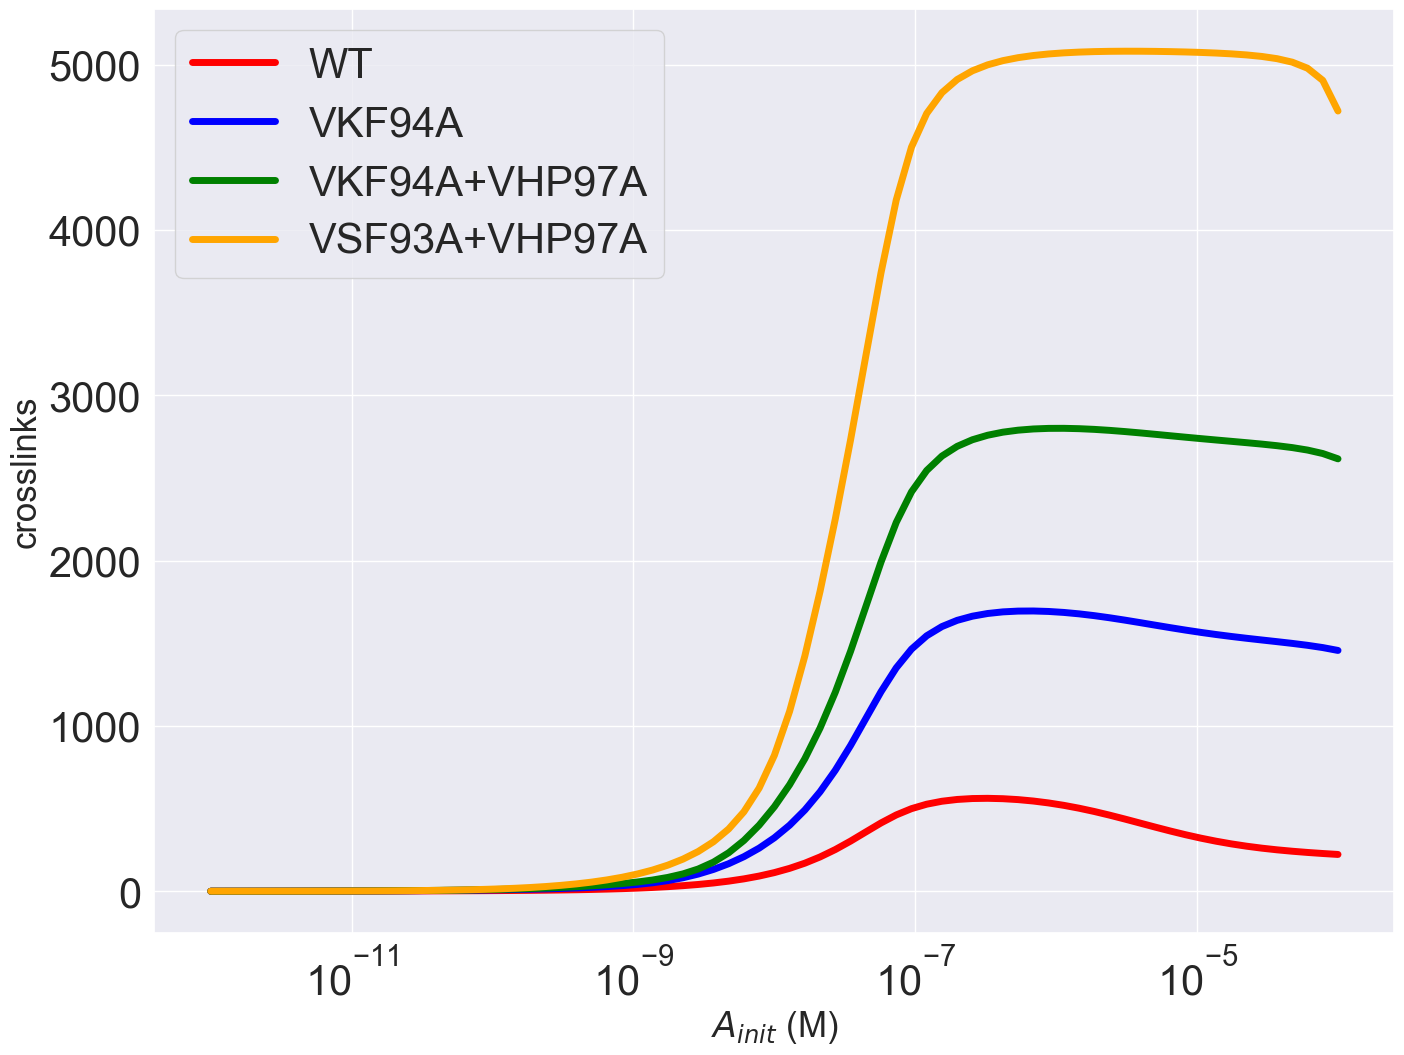

In [ ]:
sns.set_context('talk')
sns.set_theme()
colors=['red', 'blue', 'green', 'orange']
fig, ax = plt.subplots(figsize=(16, 12))
labels = ['WT', 'VKF94A', 'VKF94A+VHP97A', 'VSF93A+VHP97A']
for i in range(len(CD4_on_rates)):
    #ax.semilogx(A0s, crosslinks[i, :], label=CD4_variants[i], lw=5, c=colors[i])
    ax.semilogx(A0s, crosslinks_1[i, :],  lw=5, c=colors[i], label = labels[i])

ax.tick_params(labelsize=30)
ax.legend(loc='best', fontsize=30)
ax.set_xlabel(r'$A_{init}$ (M)', fontsize=25)
ax.set_ylabel('crosslinks', fontsize=25)
plt.show()

In [ ]:
"""
rtots = np.geomspace(1e4, 1e6, 250)
ftots = [1e4, 1e5, 1e6]
A0s = np.geomspace(1e-12, 1e-5, 750)
solution_array = np.zeros((len(ftots), len(rtots)))

def EC50_finder(array, A0s):
    half_max = 0.5*np.max(array) 
    half_max_array = half_max*np.ones_like(array)
    indicies = np.argwhere(np.diff(np.sign(half_max_array-array)))
    return A0s[indicies[0]]

kon = 1e5
koff = 1e-4
D_t = 5e-14
qon = 6.5e3
qoff = 4.7e-3
D_f = 7.4e-14

for i, ftot in enumerate(ftots):
    print(i)
    for j, rtot in enumerate(rtots):
        holder = np.zeros_like(A0s)
        for k, Ainit in enumerate(A0s):
             holder[k] = calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot)

        solution_array[i, j] = EC50_finder(holder/ftot, A0s) 
            """

'\nrtots = np.geomspace(1e4, 1e6, 250)\nftots = [1e4, 1e5, 1e6]\nA0s = np.geomspace(1e-12, 1e-5, 750)\nsolution_array = np.zeros((len(ftots), len(rtots)))\n\ndef EC50_finder(array, A0s):\n    half_max = 0.5*np.max(array) \n    half_max_array = half_max*np.ones_like(array)\n    indicies = np.argwhere(np.diff(np.sign(half_max_array-array)))\n    return A0s[indicies[0]]\n\nkon = 1e5\nkoff = 1e-4\nD_t = 5e-14\nqon = 6.5e3\nqoff = 4.7e-3\nD_f = 7.4e-14\n\nfor i, ftot in enumerate(ftots):\n    print(i)\n    for j, rtot in enumerate(rtots):\n        holder = np.zeros_like(A0s)\n        for k, Ainit in enumerate(A0s):\n             holder[k] = calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot)\n\n        solution_array[i, j] = EC50_finder(holder/ftot, A0s) \n            '

In [ ]:
"""
fig, ax = plt.subplots(figsize = (12, 8))
labels = [r'$10^4$', r'$10^5$', r'$10^6$']
for i in range(len(ftots)):
    label = r'$f_{tot} = $' + labels[i]
    ax.loglog(rtots, solution_array[i, :], label=label, lw=5)

ax.tick_params(labelsize=20)
ax.legend(loc='best', fontsize=20)
ax.set_xlabel(r'$r_{tot}$', fontsize=20)
ax.set_ylabel(r'$EC50$', fontsize=20)
ax.set_ylim(1e-12, 1e-8)
plt.show()
"""

"\nfig, ax = plt.subplots(figsize = (12, 8))\nlabels = [r'$10^4$', r'$10^5$', r'$10^6$']\nfor i in range(len(ftots)):\n    label = r'$f_{tot} = $' + labels[i]\n    ax.loglog(rtots, solution_array[i, :], label=label, lw=5)\n\nax.tick_params(labelsize=20)\nax.legend(loc='best', fontsize=20)\nax.set_xlabel(r'$r_{tot}$', fontsize=20)\nax.set_ylabel(r'$EC50$', fontsize=20)\nax.set_ylim(1e-12, 1e-8)\nplt.show()\n"